In [2]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split

from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
pd.options.mode.chained_assignment = None

# Evaluation

In [8]:
# Fill this function to construct a data frame X that contains your final features extracted from the dataset
def construct_features(player_data, points_data):
    # The set will contain the features of the each team
    feature_set = points_data.copy()
    #------------Feature 1------------
    # Feature 1 is the previous season points. If there is no previous season for a spesific team then
    # the point value gets (mean)-3*(standard deviation) of the given season. Since previous season is very
    # important for the performance of the current season, we though that it will tell a lot about the success
    # of a club.
    club_lb = feature_set.groupby('Club').agg({'Points':lambda x:max(0, x.mean()-3*x.std())})
    feature_set = feature_set.set_index(['Club', 'Season']).sort_index()
    prev_season_scores = []
    
    #------------Feature 4------------
    # Feature 4 is the sum of squares of (average age of the players of the champions' - player ages)
    # for a team. When a team players get older or if they are too young or the difference between
    # players' ages are too much it affects the team's performance negatively. 
    # Hence, there should be a negative correlation between feature 4 and the team's success
    idx = points_data.groupby('Season')['Points'].transform(max) == points_data['Points']
    champions = points_data[idx]
    del idx
    champions.set_index(['Club', 'Season'], inplace=True)
    
    #------------Feature 2------------ 
    # Feature 2 is for the big clubs. Championship should be considered when calculating the performance of a team.
    # At least 2 of the first three clubs in each season are from these champions. The feature gets 1 for champions
    # and 0 for the rest.
    
    was_champion = []
    
    for row in feature_set.itertuples():
        (club, season), rest = row[0], row[1:len(row)]
        prev_season = season - 1
        if (club, prev_season) in feature_set.index:
            prev_season_scores.append(feature_set.loc[(club, prev_season)]['Points'])
        else:
            prev_season_scores.append(club_lb.loc[club, 'Points'])
        
        was_champion.append(int(club in champions.index))
    del club_lb
    
    feature_set['prev_season_score'] = prev_season_scores
    del prev_season_scores
    #------------Feature 1------------
    
    feature_set['was_champion'] = was_champion
    del was_champion
    #------------Feature 2------------
    
    #------------Feature 3&5------------
    # Feature 3 is the average market value of the club. This is again keystone for the success.
    # Feature 5 is the ratio of the multinational players in a team. This relation is not obvious
    # it should be observed.
    player_data_club_season = player_data.groupby(['Club', 'Season'])
    cs_averages = player_data_club_season['Age', 'Multinational', 'Market Value'].mean()
    feature_set[['avg_age', 'multinationality', 'avg_market_value']] = cs_averages
    #------------Feature 3&5------------
    
    champions['avg_age'] = cs_averages['Age']
    del cs_averages
    opt_age = champions['avg_age'].mean()
    def sum_of_sq(list):
        return sum(i*i for i in list)
    ssq = player_data_club_season.agg({'Age':lambda x:sum_of_sq(x-opt_age)})
    feature_set['ssq_opt_age'] = ssq
    #------------Feature 4------------
    
    #------------Feature 6------------
    # Feature 6 is the most 2 nations of players in the champion team. It gave 4 nations: Turkey, Brazil,
    # Germany and Argentina. Maybe there should be harmony between players from those nations.
    cs_nationality_counts = {}
    for row in player_data.itertuples():
        index, rest = row[0], row[1:len(row)]
        (season, club) = rest[0:2]
        if (club, season) not in cs_nationality_counts:
            cs_nationality_counts[(club, season)] = {}
        if rest[5] not in cs_nationality_counts[(club, season)]:
            cs_nationality_counts[(club, season)][rest[5]] = 1
        else:
            cs_nationality_counts[(club, season)][rest[5]] += 1
    
    most_nations = set()
    for row in champions.itertuples():
        (club, season), rest = row[0], row[1:len(row)]
        most = second_most = ('asdasd', 0)
        for nation, count in cs_nationality_counts[(club, season)].items():
            if most[1] < count:
                second_most = most
                most = (nation, count)
            elif second_most[1] < count:
                second_most = (nation, count)
        most_nations.add(most[0])
        most_nations.add(second_most[0])
    del champions
    
    def get_nation_ratio(x, **kwargs):
        nation = kwargs['Nation']
        club, season = x['Club'].iloc[0], x['Season'].iloc[0]
        if (club, season) not in cs_nationality_counts:
            return 0
        elif nation not in cs_nationality_counts[(club, season)]:
            return 0
        else:
            return cs_nationality_counts[(club, season)][nation] / \
            sum(cs_nationality_counts[(club, season)].values())
    for nation in most_nations:
        feature_set['from_' + nation] = player_data_club_season[['Club', 'Season']].\
        apply(get_nation_ratio, Nation = nation)
    del player_data_club_season
    del most_nations
    #------------Feature 6------------
    
    #------------Feature 7------------
    # Feature 7 is the order of the club in the previous season. It differs from Feature 1
    # because the orders are not that much dependant on the points. If there is no previous season
    # for the club then it gets 0 in order not to affect the result.
    def get_club_order(x):
        res = {}
        i = 1
        for row in x.sort_values('Points', ascending=0)['Club'].iteritems():
            res[row[1]] = i
            i += 1
        return res
    season_orders = points_data.groupby('Season', sort=False).apply(get_club_order).to_dict()
    prev_season_orders = []
    for row in feature_set.itertuples():
        (club, season), rest = row[0], row[1:len(row)]
        prev_season = season - 1
        if prev_season in season_orders and club in season_orders[prev_season]:
            prev_season_orders.append(season_orders[prev_season][club])
        else:
            prev_season_orders.append(0)
    feature_set['prev_season_order'] = prev_season_orders
    #------------Feature 7------------
    
    #------------Feature 8------------
    # Feature 8 is the old players in the team. The team conserves its stability by not transfering
    # too many players. The players are familiar with each other and it also means harmony between players.
    player_csp_df = player_data.copy()
    player_csp_df = player_csp_df.set_index(['Club', 'Season', 'Player']).sort_index()
    player_csp_df.drop(['Age', 'Nationality', 'Multinational', 'Foreign', 'Market Value'],inplace=True,axis=1)
    same_players = []
    
    for row in player_csp_df.itertuples():
        (club, season, player) = row[0]
        prev_season = season-1
        if (club, prev_season, player) in player_csp_df.index:
            same_players.append(1)
        else:
            same_players.append(0)
    
    player_cs_df = player_data.copy()
    player_cs_df = player_cs_df.set_index(['Club', 'Season']).sort_index()
    player_cs_df.drop(['Player', 'Age', 'Nationality', 'Multinational', 'Foreign', 'Market Value'],inplace=True,axis=1)
    
    #------------Feature 10------------
    # Feature 10 is the total number of players in a team. The player rotation and shift is very important
    # especially for injuries. There should be an optimal number of players in a team. 
    num_of_players = player_cs_df.copy()
    num_of_players['num_of_players'] = ''
    num_of_players = num_of_players.groupby(num_of_players.index).count()
    feature_set['num_of_players'] = num_of_players['num_of_players']
    #------------Feature 10-----------
    
    
    player_cs_df['played_prev_season'] = same_players
    player_cs_df = player_cs_df.groupby(player_cs_df.index).sum()
    feature_set['num_of_ex_players'] = player_cs_df['played_prev_season']
    #------------Feature 8------------
    
    #------------Feature 9------------
    # Feature 9 is the seasons. We thought that some teams increase their performance season by season.
    # However this is not very meaningful for the most of the teams.
    seasons = []
    for row in feature_set.itertuples():
        (club, season) = row[0]
        seasons.append(season)
    
    feature_set['season'] = seasons
    #------------Feature 9------------
    
    #------------Feature 11------------
    # Feature 11 is the ratio of old players in a team. This feature is not needed when Feature 8&10 are 
    # used.
    feature_set['old_player_ratio'] = feature_set['num_of_ex_players'] / feature_set['num_of_players']
    #------------Feature 11------------
    return feature_set.drop('Points', axis=1)


In [9]:
# Fill this function to construct a data frame y that contains the labels of the test data
def construct_labels(points_df):
    points_df = points_df.set_index(['Club', 'Season']).sort_index()
    return points_df

In [10]:
# If you try to choose to predict points instead of rankings then you should implement this function as well
# to generate rankings. If you predict the rankings directly, you can leave this function as it is.
def convert_points_to_rankings(predictions):
    predictions=pd.DataFrame(predictions)
    predictions.sort_values(by=predictions.columns[0], ascending=False, inplace=True)
    predictions[predictions.columns[0]]=range(1,len(predictions)+1)
    predictions.rename(columns = {predictions.columns[0]:'Ranks'}, inplace = True)
    predictions.sort_index(inplace = True)
    return predictions

In [11]:
def reduce_to_2D(X, Y):
    color = Y
    n_neighbors = 10
    n_components = 2

    fig = plt.figure(figsize=(15, 8))
    plt.suptitle('Manifold Learning with %i points, %i neighbors'
                 % (len(X), n_neighbors), fontsize=14)

    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='auto',
                                            method=method).fit_transform(X)
        t1 = time()
        print('%s: %.2g sec' % (methods[i], t1 - t0))

        ax = fig.add_subplot(252 + i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title('%s (%.2g sec)' % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    t0 = time()
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print('Isomap: %.2g sec' % (t1 - t0))
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title('Isomap (%.2g sec)' % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print('MDS: %.2g sec' % (t1 - t0))
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title('MDS (%.2g sec)' % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print('SpectralEmbedding: %.2g sec' % (t1 - t0))
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title('SpectralEmbedding (%.2g sec)' % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print('t-SNE: %.2g sec' % (t1 - t0))
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title('t-SNE (%.2g sec)' % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

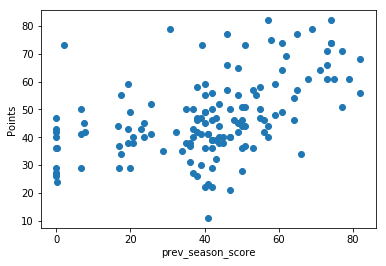

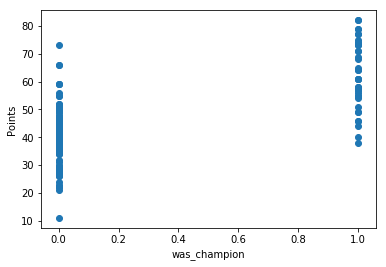

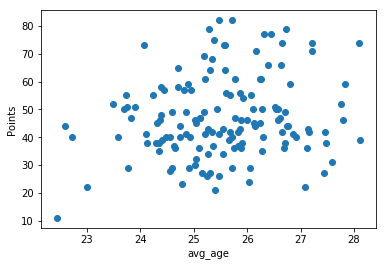

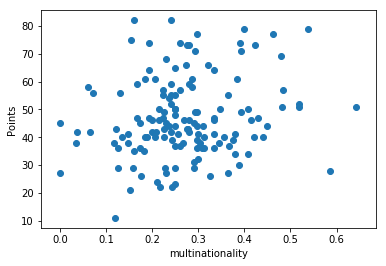

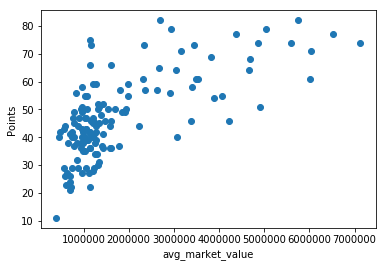

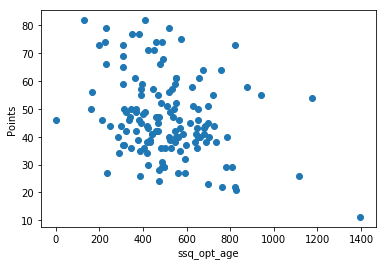

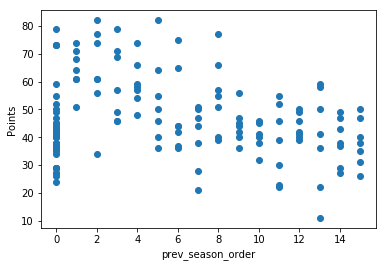

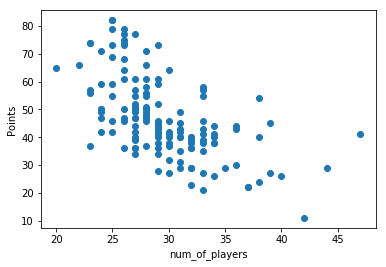

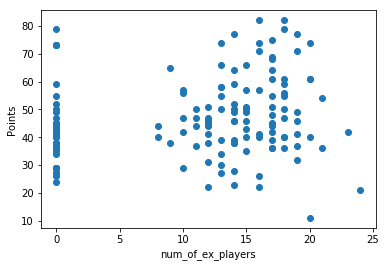

standard: 0.023 sec
ltsa: 0.035 sec
hessian: 0.053 sec
modified: 0.041 sec
Isomap: 0.0086 sec
MDS: 0.057 sec
SpectralEmbedding: 0.019 sec
t-SNE: 2.4 sec


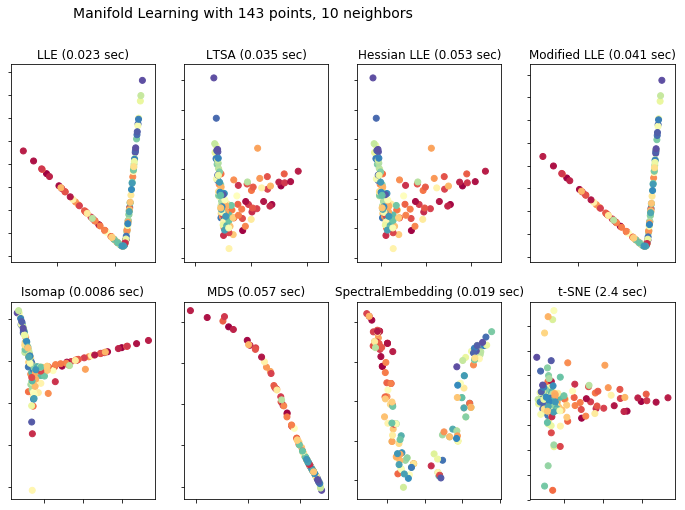

0.7254901960784316


In [20]:
# This function will evaluate your features test performance using the ranking predictions
def compute_test_score(outfile_name):
    
    X_train = construct_features(pd.read_excel('train_data.xlsx',sheet_name='Player'), 
                            pd.read_excel('train_data.xlsx',sheet_name='Points'))
    y_train = construct_labels(pd.read_excel('train_data.xlsx',sheet_name='Points'))
    
    X_test = X_train[X_train['season'] == 2013]

    y_test = y_train.iloc[y_train.index.get_level_values('Season') == 2013]
    
    X_train = X_train[X_train['season'] != 2013]
    y_train = y_train.iloc[y_train.index.get_level_values('Season') != 2013]
    
    #----- This block of code is used to determine which features are nice for predictions
    # We used lasso regression for that and eliminate the features from the feature set whose 
    #coefficients are almost 0, meaning irrelevant from the points the teams get. It gave the set of
    #[prev_season_score, was_champion, avg_age, avg_market_value, ssq_opt_age,
    #prev_season_order, num_of_players, num_of_ex_players]
    #We also thought that these features would be the best after the result we were convinced
    #Then we also tried other features and calculated tau. Other features, from_Turkey
    # from_Brazil, from_Germany, from_Argentina and season, were affecting tau aversely
    #except multinationality. After adding that, we got the best feature set.
    
    #--------------------STARTS----------------------------------
    #from sklearn import linear_model
    #clf = linear_model.Lasso(alpha=0.1)
    #lasso_model = clf.fit([list(i[1:len(i)]) for i in X_train.itertuples()],
    #                   list(y_train['Points']))
    #list(X_train.columns.values[lasso_model.coef_ != 0])
    
    #--------------------ENDS----------------------------------
    
    best_feature_set=[
     'prev_season_score',
     'was_champion',
     'avg_age',
     'multinationality',
     'avg_market_value',
     'ssq_opt_age',
     'prev_season_order',
     'num_of_players',
     'num_of_ex_players']

    X_train=pd.DataFrame(X_train[best_feature_set])
    X_test=pd.DataFrame(X_test[best_feature_set])
    
    # The relation between the features and points can be seen with these figures.
    for feature in best_feature_set:
        plt.scatter(X_train[feature],y_train['Points'])
        plt.xlabel(feature)
        plt.ylabel('Points')    
        plt.show()
    
    # Here are manifold learning visualization methods that try to reduce the features to 2D with colored ranks
    reduce_to_2D(X_train, convert_points_to_rankings(y_train)['Ranks'])
        
    # X_test should contain the feature you engineered and y_test should contain the corresponding labels, which are team rankings 
    #X_test = construct_features(pd.read_excel('test_data.xlsx',sheet_name='Player'),
                               # pd.read_excel('test_data.xlsx',sheet_name='Points'))
   
    #X_test=pd.DataFrame(X_test[best_feature_set])
    
    #y_test = construct_labels(pd.read_excel('test_data.xlsx',sheet_name='Points'))
    
   

    
    # This is the regression model you will use
    final_model = LinearRegression(fit_intercept=True)
    final_model.fit(X_train,y_train)
    # Your model's predictions will be stored in this array
    predictions = final_model.predict(X_test)
    predictions=pd.DataFrame(predictions)
    predictions=predictions.set_index(X_test.index)
    predictions.columns = ['Points']
    # Your model can predict either points or rankings. If necessary, change the function above
    predictions = convert_points_to_rankings(predictions)
    y_test=convert_points_to_rankings(y_test)
    # Your performance on the test set
    tau, _ = kendalltau(predictions, y_test)
    # Print tau both to file and screen
    print(tau)
    f = open(outfile_name, 'w')
    f.write(str(tau))
    f.close()

#outfile name should have the format ID1_ID2_ID3.txt
outfile_name = '2013400171_2014400165_2013402174.txt'
compute_test_score(outfile_name)